In [1]:
from sys import path
path.append('..')
path.append('../src/')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from keras.layers import GlobalAvgPool2D, Layer, Input
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.ops import Tensor

from typing import List

from utils import plot, load
from custom_losses import wing_loss
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import eye_localization_accuracy, eye_localization_fvc

%matplotlib inline

Using TensorFlow backend.


# Encoder 

In [2]:
FILE_MODEL_CLF = "../models/unsupervised_supervised/model_2020_07_12-02_22_54.h5"

model = load_model(FILE_MODEL_CLF)

model_encoder = Model(inputs=model.inputs, outputs=model.get_layer(name='encoded').output)
model_encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_____________________________________________________

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Decoder

In [3]:
FILE_MODEL_CLF = "../models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5"

custom_objects = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "specificity": specificity,
    "fbeta": fbeta,
    "negative_predictive_value": npv,
    "matthews_correlation_coefficient": mcc,
    "wing_loss": wing_loss,
    "eye_localization_accuracy": eye_localization_accuracy
}

model = load_model(FILE_MODEL_CLF, custom_objects=custom_objects)
model.summary()

Instructions for updating:
Use tf.cast instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________

In [4]:
def get_layers(model: Model, list_names: List[str]) -> List[Layer]:
    return [model.get_layer(name=name) for name in list_names]

def append_layers_from_output(layer_output: Tensor, list_layers: List[Layer]) -> Tensor:
    x = layer_output
    for layer in list_layers:
        x = layer(x)
    return x

In [5]:
list_layers = [
    "4_conv",
    "4_bn",
    "4_relu",
    "3_conv",
    "3_bn",
    "3_relu",
    "2_conv",
    "2_bn",
    "2_relu",
    "1_conv",
    "1_bn",
    "1_relu",
    "decoded"
]

layers_decoder = get_layers(model, list_layers)

decoder_input = Input(shape=(10, 10, 256), name="encoded")
decoder_layers = append_layers_from_output(decoder_input, layers_decoder)

model_decoder = Model(name="decoder", inputs=decoder_input, outputs=decoder_layers)
model_decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded (InputLayer)         (None, 10, 10, 256)       0         
_________________________________________________________________
4_conv (Conv2DTranspose)     (None, 20, 20, 256)       590080    
_________________________________________________________________
4_bn (BatchNormalization)    (None, 20, 20, 256)       1024      
_________________________________________________________________
4_relu (Activation)          (None, 20, 20, 256)       0         
_________________________________________________________________
3_conv (Conv2DTranspose)     (None, 40, 40, 128)       295040    
_________________________________________________________________
3_bn (BatchNormalization)    (None, 40, 40, 128)       512       
_________________________________________________________________
3_relu (Activation)          (None, 40, 40, 128)       0   

# Embeddings Aritmetic 

In [6]:
def embeddings_aritmetic_2(im_1, im_2, encoder, decoder):
    emb_1 = encoder.predict(np.expand_dims(im_1 / 255, axis=0))
    emb_2 = encoder.predict(np.expand_dims(im_2 / 255, axis=0))
    emb_res = emb_1 + emb_2

    return decoder.predict(emb_res).squeeze() * 255


def embeddings_aritmetic_3(im_1, im_2, im_3, encoder, decoder):
    emb_1 = encoder.predict(np.expand_dims(im_1 / 255, axis=0))
    emb_2 = encoder.predict(np.expand_dims(im_2 / 255, axis=0))
    emb_3 = encoder.predict(np.expand_dims(im_3 / 255, axis=0))
    emb_res = emb_1 - emb_2 + emb_3

    return decoder.predict(emb_res).squeeze() * 255


def plot_images(list_imgs, figsize=(12, 8)):
    plt.figure(figsize=figsize)

    for i, im in enumerate(list_imgs, start=1):
        plt.subplot(2, len(list_imgs) // 2, i)
        plt.imshow(im.astype(np.uint8)[:, :, ::-1])
        plt.axis('off')

2 of 2


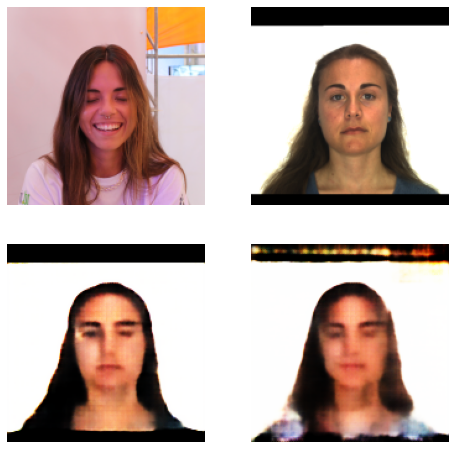

In [7]:
file_1 = "../data/cropped_faces/images/visio_icao_expotec_1192.png" # bgd + eyes closed + mouth + skin tone
file_2 = "../data/cropped_faces/images/AR_w-052-14.png" # full compliant

img_1, img_2 = load.images_from_list_files(
    [file_1, file_2], 
    output_size=(160, 160), 
    interpolation=cv2.INTER_AREA
)

im_ori = embeddings_aritmetic_2(img_2, img_2, model_encoder, model_decoder)
im_dec = embeddings_aritmetic_2(img_1, img_2, model_encoder, model_decoder)

plot_images([img_1, img_2, im_ori, im_dec], figsize=(8, 8))

2 of 2


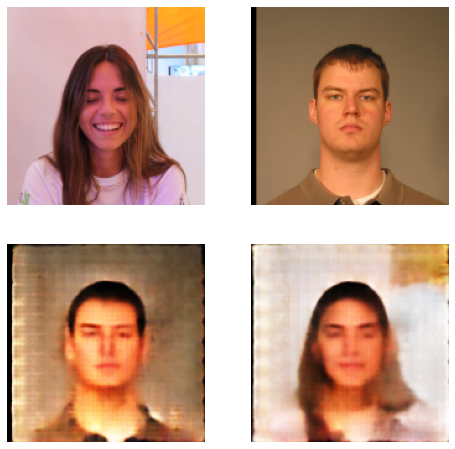

In [8]:
file_1 = "../data/cropped_faces/images/visio_icao_expotec_1192.png" # bgd + eyes closed + mouth + skin tone
file_2 = "../data/cropped_faces/images/FRGC_04256d145.jpg" # full compliant

img_1, img_2 = load.images_from_list_files(
    [file_1, file_2], 
    output_size=(160, 160), 
    interpolation=cv2.INTER_AREA
)

im_ori = embeddings_aritmetic_2(img_2, img_2, model_encoder, model_decoder)
im_dec = embeddings_aritmetic_2(img_1, img_2, model_encoder, model_decoder)

plot_images([img_1, img_2, im_ori, im_dec], figsize=(8, 8))

3 of 3


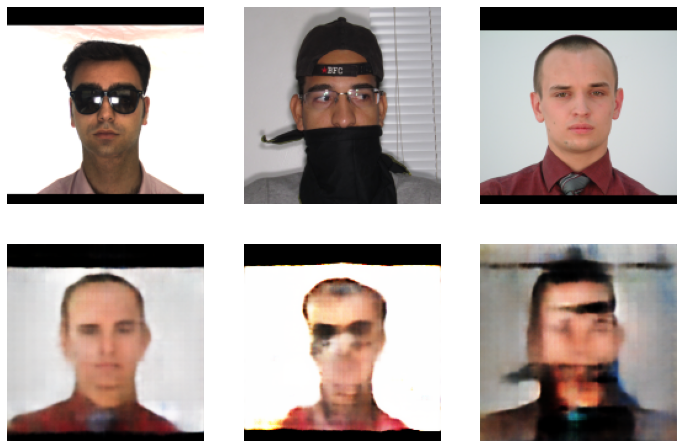

In [9]:
file_1 = "../data/cropped_faces/images/AR_FDB_m-008-21.png" # oculos + bgd
file_2 = "../data/cropped_faces/images/VSOFT_001.png" # bgd + veu
file_3 = "../data/cropped_faces/images/PUT_00372015.JPG" # full compliant

img_1, img_2, img_3 = load.images_from_list_files(
    [file_1, file_2, file_3], 
    output_size=(160, 160), 
    interpolation=cv2.INTER_AREA
)

im_ori = embeddings_aritmetic_3(img_3, img_3, img_3, model_encoder, model_decoder)
im_dec_1 = embeddings_aritmetic_3(img_1, img_2, img_3, model_encoder, model_decoder)
im_dec_2 = embeddings_aritmetic_3(img_2, img_1, img_3, model_encoder, model_decoder)

plot_images([img_1, img_2, img_3, im_ori, im_dec_1, im_dec_2])